# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Rizqi Amalia Kartika
- **Email:** mc219d5x1732@student.devacademy.id
- **ID Dicoding:** MC219D5X1732

## Menentukan Pertanyaan Bisnis

- Bagaimana pengaruh hujan terhadap kualitas udara?
- Bagaimana pola tingkat polusi udara (PM2.5, NO2, O3) berdasarkan waktu (jam dalam sehari)?

## Import Semua Packages/Library yang Digunakan

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import kruskal
from sklearn.cluster import KMeans

## Data Wrangling

### Gathering Data

In [1]:
import pandas as pd

df = pd.read_csv('/Users/rizqiamaliakartika/PYTHON/DICODING/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv')

print(df.head())


   No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1020.8 -19.7   0.0    E   0.5  Dingling  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  1022.3 -19.4   0.0    N   2.1  Dingling  


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34285 non-null  float64
 6   PM10     34408 non-null  float64
 7   SO2      34334 non-null  float64
 8   NO2      33830 non-null  float64
 9   CO       33052 non-null  float64
 10  O3       33850 non-null  float64
 11  TEMP     35011 non-null  float64
 12  PRES     35014 non-null  float64
 13  DEWP     35011 non-null  float64
 14  RAIN     35013 non-null  float64
 15  wd       34924 non-null  object 
 16  WSPM     35021 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB
None


In [3]:
print(df.describe())

                 No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637     11.500000   
std    10122.249256      1.177213      3.448752      8.800218      6.922285   
min        1.000000   2013.000000      1.000000      1.000000      0.000000   
25%     8766.750000   2014.000000      4.000000      8.000000      5.750000   
50%    17532.500000   2015.000000      7.000000     16.000000     11.500000   
75%    26298.250000   2016.000000     10.000000     23.000000     17.250000   
max    35064.000000   2017.000000     12.000000     31.000000     23.000000   

              PM2.5          PM10           SO2           NO2            CO  \
count  34285.000000  34408.000000  34334.000000  33830.000000  33052.000000   
mean      65.989497     83.739723     11.749650     27.585467    904.896073   
std       72.267723     79.541685     15.519259    

**Insight:**
Data diambil dari file CSV menggunakan pandas, dan informasi awal seperti tampilan lima baris pertama, tipe data, serta statistik deskriptif ditampilkan untuk memahami dataset.

### Assessing Data

In [4]:
# Mengecek missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 No            0
year          0
month         0
day           0
hour          0
PM2.5       779
PM10        656
SO2         730
NO2        1234
CO         2012
O3         1214
TEMP         53
PRES         50
DEWP         53
RAIN         51
wd          140
WSPM         43
station       0
dtype: int64


In [5]:
# Mengecek duplicate values
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


In [6]:
# Mengecek inkonsistensi pada fitur kategorikal (contoh: arah angin 'wd')
print("Unique values in 'wd':", df['wd'].unique())


Unique values in 'wd': ['E' 'ENE' 'NNE' 'N' 'NNW' 'NW' 'NE' 'SW' 'SSW' 'WSW' 'ESE' 'SE' 'S' 'WNW'
 'SSE' 'W' nan]


In [7]:
numerical_cols = df.select_dtypes(include=['number']).columns

# Fungsi untuk mengecek outlier menggunakan IQR
def detect_outliers_iqr(data, columns):
    outliers_dict = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers_dict[col] = len(outliers)
    
    return outliers_dict

# Mengecek jumlah outlier pada setiap kolom numerik
outliers_count = detect_outliers_iqr(df, numerical_cols)

# Menampilkan hasil jumlah outlier per kolom
print("Jumlah Outlier per Kolom:\n", outliers_count)

Jumlah Outlier per Kolom:
 {'No': 0, 'year': 0, 'month': 0, 'day': 0, 'hour': 0, 'PM2.5': 1831, 'PM10': 1430, 'SO2': 2787, 'NO2': 1805, 'CO': 1848, 'O3': 1616, 'TEMP': 0, 'PRES': 0, 'DEWP': 0, 'RAIN': 1350, 'WSPM': 2382}


**Insight:**
Proses ini bertujuan untuk mengevaluasi kualitas data dengan mengecek missing values, duplikasi, serta inkonsistensi pada fitur kategorikal.

### Cleaning Data

Mengatasi missing values
- Untuk Data Polutan Udara (PM2.5, PM10, SO2, NO2, CO, O3)
Menggunakan median karena data polusi udara cenderung memiliki outlier.
- Untuk Data Cuaca (TEMP, PRES, DEWP, RAIN, WSPM)
Menggunakan mean karena distribusinya biasanya lebih normal.
- Untuk Data Kategorikal (wd - Arah Angin)
Menggunakan mode (nilai terbanyak).

In [8]:
df['PM2.5'] = df['PM2.5'].fillna(df['PM2.5'].median())
df['PM10'] = df['PM10'].fillna(df['PM10'].median())
df['SO2'] = df['SO2'].fillna(df['SO2'].median())
df['NO2'] = df['NO2'].fillna(df['NO2'].median())
df['CO'] = df['CO'].fillna(df['CO'].median())
df['O3'] = df['O3'].fillna(df['O3'].median())

In [9]:
df['TEMP'] = df['TEMP'].fillna(df['TEMP'].mean())
df['PRES'] = df['PRES'].fillna(df['PRES'].mean())
df['DEWP'] = df['DEWP'].fillna(df['DEWP'].mean())
df['RAIN'] = df['RAIN'].fillna(df['RAIN'].mean())
df['WSPM'] = df['WSPM'].fillna(df['WSPM'].mean())

In [10]:
df['wd'] = df['wd'].fillna(df['wd'].mode()[0])

In [11]:
print("Missing values setelah cleaning:\n", df.isnull().sum())

Missing values setelah cleaning:
 No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64


In [12]:
# Menggunakan IQR method untuk menghapus outlier
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Daftar kolom dengan outlier
outlier_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'RAIN', 'WSPM']

# Menghapus outlier
df_cleaned = remove_outliers(df, outlier_cols)

print("Jumlah data setelah menghapus outlier:", df_cleaned.shape)

Jumlah data setelah menghapus outlier: (22425, 18)


**Insight:**
Missing values diatasi dengan salah satu diantara median,mean, dan mode, memastikan data lebih bersih dan siap untuk analisis lebih lanjut.

## Exploratory Data Analysis (EDA)

### Explore ...

In [13]:
print(df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].describe())


              PM2.5          PM10           SO2           NO2            CO  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      65.434317     83.295585     11.609128     27.283320    887.400896   
std       71.555278     78.859721     15.387066     25.963693    879.868464   
min        3.000000      2.000000      0.285600      1.026500    100.000000   
25%       14.000000     26.000000      2.000000      9.000000    300.000000   
50%       41.000000     60.000000      5.000000     19.000000    600.000000   
75%       91.000000    116.000000     14.000000     37.000000   1100.000000   
max      881.000000    905.000000    156.000000    205.000000  10000.000000   

                 O3          TEMP          PRES          DEWP          RAIN  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean      68.287028     13.686111   1007.760278      1.505495      0.060366   
std       52.843495     11.356720     10.218370    

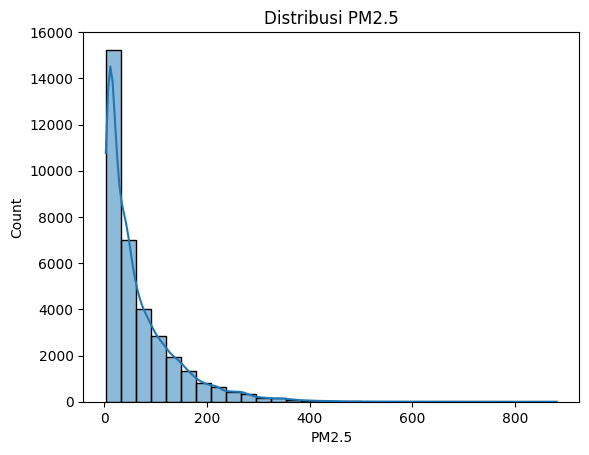

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram untuk PM2.5
sns.histplot(df['PM2.5'], bins=30, kde=True)
plt.title("Distribusi PM2.5")
plt.show()

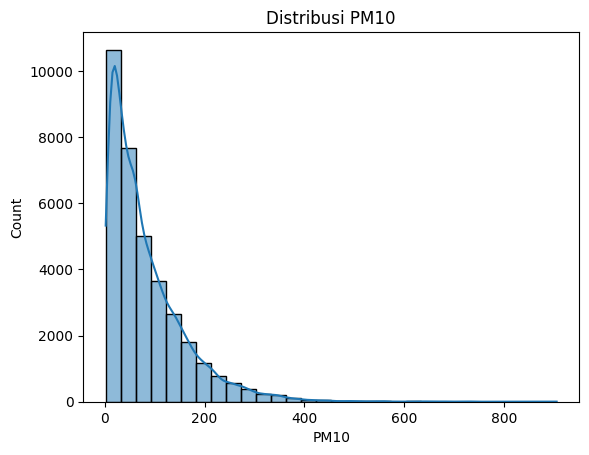

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram untuk PM10
sns.histplot(df['PM10'], bins=30, kde=True)
plt.title("Distribusi PM10")
plt.show()

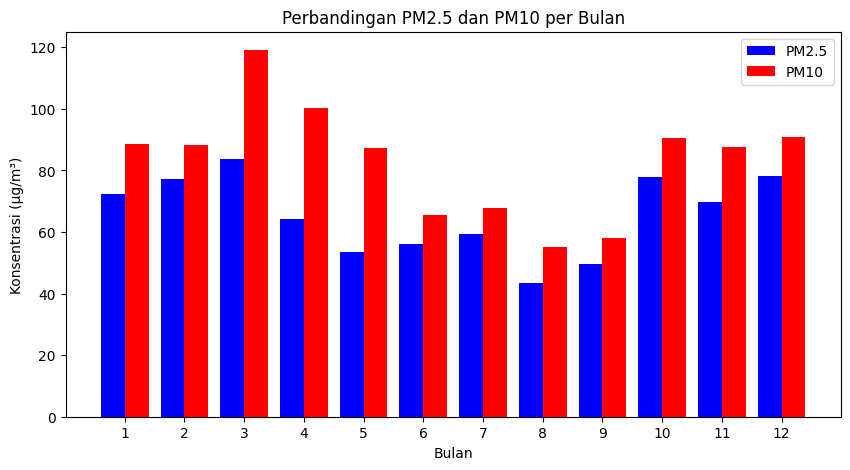

In [16]:
# Hitung rata-rata PM2.5 dan PM10 per bulan
df_monthly = df.groupby('month')[['PM2.5', 'PM10']].mean().reset_index()

# Plot Bar Chart
plt.figure(figsize=(10, 5))
bar_width = 0.4  # Lebar batang

# Plot PM2.5
plt.bar(df_monthly['month'] - bar_width/2, df_monthly['PM2.5'], width=bar_width, label='PM2.5', color='b')

# Plot PM10
plt.bar(df_monthly['month'] + bar_width/2, df_monthly['PM10'], width=bar_width, label='PM10', color='r')


plt.xlabel("Bulan")
plt.ylabel("Konsentrasi (µg/m³)")
plt.title("Perbandingan PM2.5 dan PM10 per Bulan")
plt.xticks(df_monthly['month'])  # Menampilkan bulan di sumbu x
plt.legend()
plt.show()

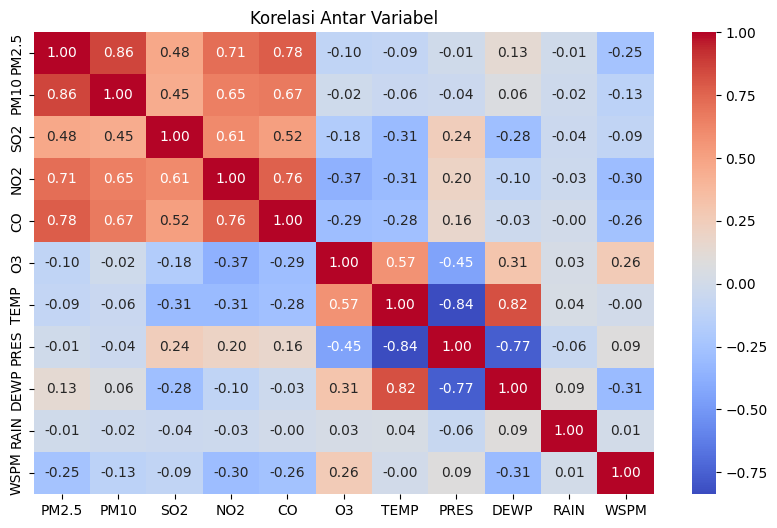

In [17]:
corr_matrix = df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Variabel")
plt.show()


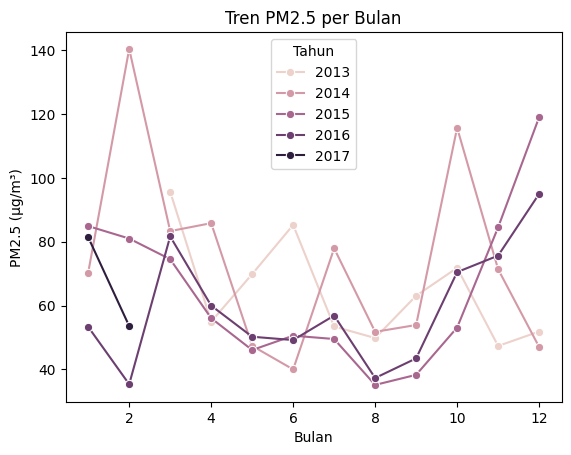

In [18]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_monthly = df.groupby(['year', 'month'])[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']].mean().reset_index()

sns.lineplot(x='month', y='PM2.5', hue='year', data=df_monthly, marker='o')
plt.title("Tren PM2.5 per Bulan")
plt.xlabel("Bulan")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend(title="Tahun")
plt.show()


**Insight:**
Analisis eksplorasi dilakukan dengan visualisasi seperti histogram dan scatter plot untuk memahami distribusi dan pola dalam dataset.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

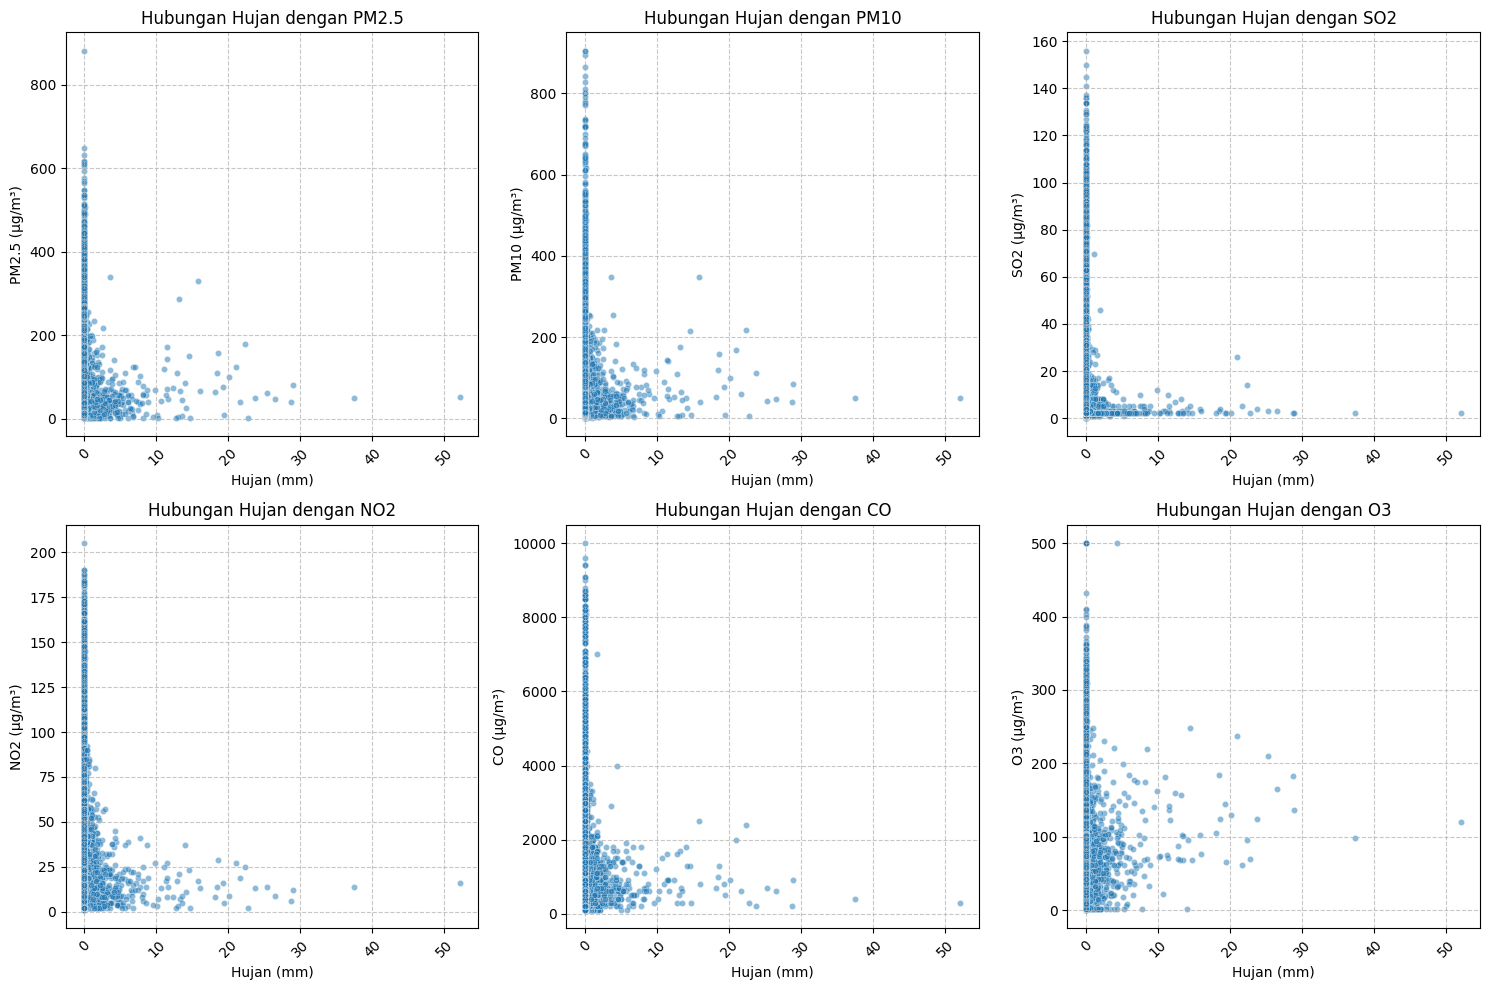

In [32]:
# Scatter plot untuk melihat hubungan hujan dan polutan
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Perbesar ukuran
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Looping dengan indeks baris dan kolom
for i, pollutant in enumerate(pollutants):
    row = i // 3  # Tentukan baris (0 atau 1)
    col = i % 3   # Tentukan kolom (0, 1, atau 2)
    
    sns.scatterplot(x=df['RAIN'], y=df[pollutant], alpha=0.5, edgecolor='w', s=20, ax=axes[row, col])
    axes[row, col].set_title(f'Hubungan Hujan dengan {pollutant}', fontsize=12)
    axes[row, col].set_xlabel('Hujan (mm)', fontsize=10)
    axes[row, col].set_ylabel(f'{pollutant} (µg/m³)', fontsize=10)
    axes[row, col].grid(True, linestyle='--', alpha=0.7)  # Tambahkan grid
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotasi label sumbu X jika perlu

plt.tight_layout()
plt.show()

### Pertanyaan 2:

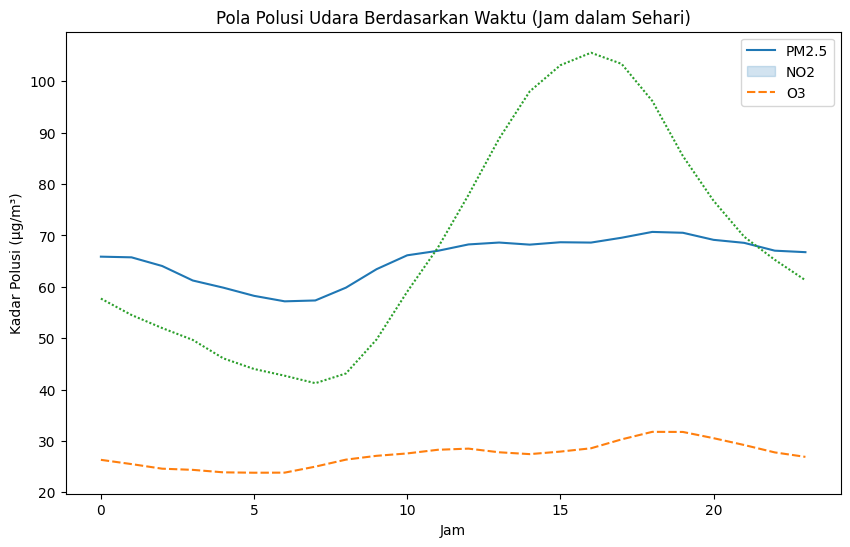

In [34]:
# Rata-rata polusi setiap jam dalam sehari
df_hourly = df.groupby('hour')[['PM2.5', 'NO2', 'O3']].mean()

# Line plot untuk melihat tren polusi harian
plt.figure(figsize=(10,6))
sns.lineplot(data=df_hourly)
plt.title("Pola Polusi Udara Berdasarkan Waktu (Jam dalam Sehari)")
plt.xlabel("Jam")
plt.ylabel("Kadar Polusi (µg/m³)")
plt.legend(['PM2.5', 'NO2', 'O3'])
plt.show()


**Insight:**
- Scatter plot digunakan untuk melihat hubungan antara curah hujan dan tingkat polusi udara
- Data dikelompokkan berdasarkan jam dalam sehari untuk melihat pola polusi udara, kemudian divisualisasikan menggunakan line plot, dengan fokus pada PM2.5, NO2, dan O3.

## Analisis Lanjutan (Opsional)

lanjutan pertanyaan 1

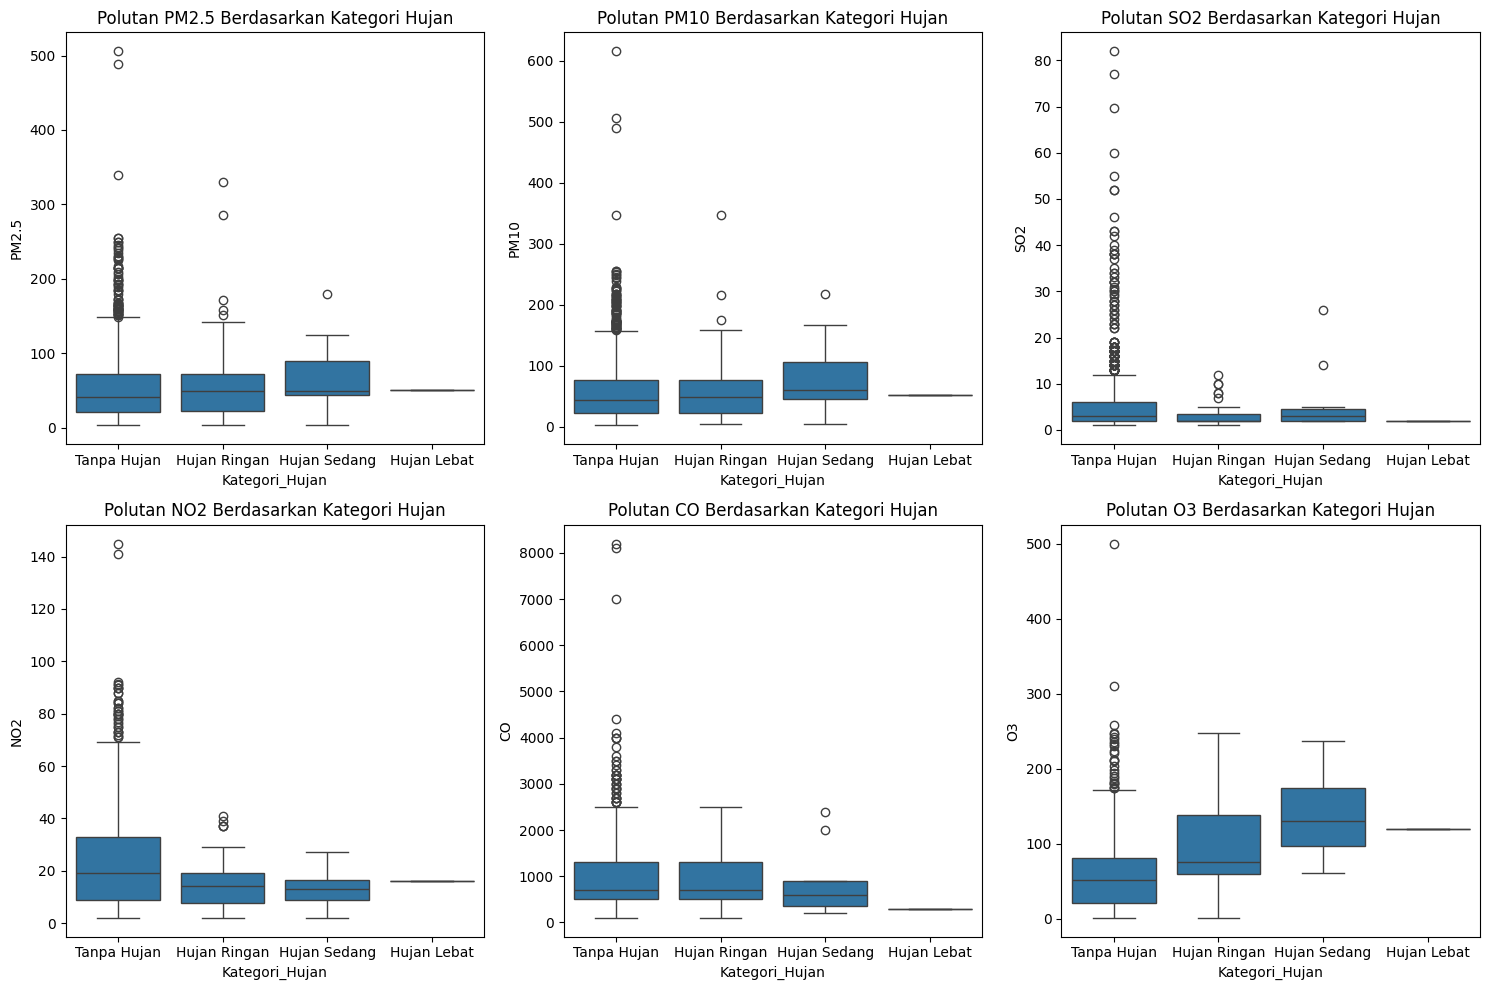

In [37]:
#Analisis berdasarkan curah hujan
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
hujan = df['RAIN']

df['Kategori_Hujan'] = pd.cut(hujan, bins=[0, 5, 20, 50, np.inf], 
                              labels=['Tanpa Hujan', 'Hujan Ringan', 'Hujan Sedang', 'Hujan Lebat'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, pollutant in enumerate(pollutants):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    sns.boxplot(x=df['Kategori_Hujan'], y=df[pollutant], ax=ax)
    ax.set_title(f'Polutan {pollutant} Berdasarkan Kategori Hujan')

plt.tight_layout()
plt.show()

## Conclusion

- Hujan membantu menurunkan polusi udara, terutama PM2.5, PM10, SO2, dan NO2, dengan efek washout yang signifikan. Namun, dampaknya terhadap CO dan O3 lebih bervariasi.

- Polusi udara bervariasi setiap hari, di mana PM2.5 dan NO2 cenderung meningkat pada siang hingga malam hari, sementara O3 mencapai puncaknya di sore hari.